# Example 1 - Pendulum
## Finding parameters of differential equations with neural networks

In this notebook, we will go through a step-by-step process of finding parameters of differential equations using deep neural networks. Here we will study the specific case of the pendulum, where we will recover the value of gravity $g$, in the pendulum equation for small angles $$\ddot{\theta} + {\frac{g}{l}}\theta =0 $$.

Let's start by importing the libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as tc

from torch import nn
from torch.optim.lr_scheduler import StepLR

Let's define our network, a feed forward

In [2]:
# Defining the neural network

class GravityNet(nn.Module):

    def __init__(self, neurons, M, output=1, activation=None):

        """
        Attributes:
            neurons: Defines the number of neurons in each hidden layer.
            M: Number of hidden layers.
            output: Number of neurons in the output layer.
            activation: The activation function for the hidden layers.
        """
        super(GravityNet, self).__init__()
        self.neurons = neurons
        self.M = M
        self.output = output

        # List to store the linear layers
        self.hidden_layers = nn.ModuleList([nn.Linear(1, neurons)])
        self.hidden_layers.extend([nn.Linear(neurons, neurons) for _ in range(M-1)])
        
        # Last linear layer
        self.output_layer = nn.Linear(neurons, output)

        # Activation function
        self.activation = activation

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        x = self.output_layer(x)
        return x
    
def analytical_solution_OHM(x_0, omega_0, t):
    return x_0 * tc.cos(omega_0 * t)

Let's calculate the analytical solution of the ODE

tensor(0.9905)


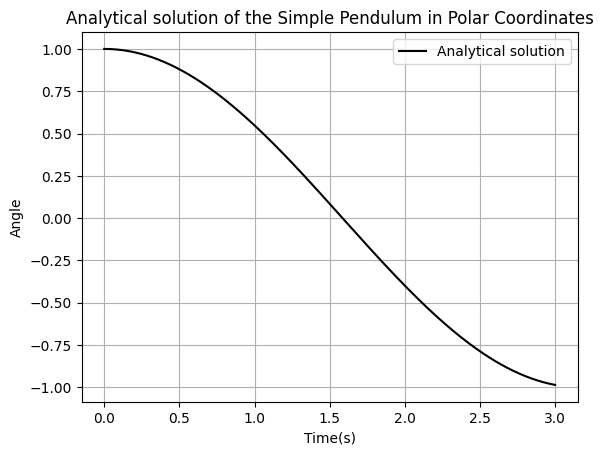

In [3]:
x_0 = 1 # Initial condition
t_i = 0 # Initial time
t_f = 3 # Final time

pendulum_length = tc.tensor(10) # Length of the pendulum in meters
Omega_0 = tc.sqrt(9.81 / pendulum_length) # Oscillation frequency
print(Omega_0)

# Creating training data
t_train = tc.linspace(t_i, t_f, 300).reshape(-1, 1) # Time
theta_train = analytical_solution_OHM(x_0=x_0, omega_0=Omega_0, t=t_train) # Analytical solution of the OHS

plt.plot(t_train.detach().numpy(), theta_train.detach().numpy(), "k-", label="Analytical solution")

# Adding labels and title
plt.ylabel("Angle")
plt.xlabel("Time(s)")
plt.title("Analytical solution of the Simple Pendulum in Polar Coordinates")
plt.legend()
plt.grid(True)
plt.show()

To represent "experimental" data, we will take random values within the analytical solution.

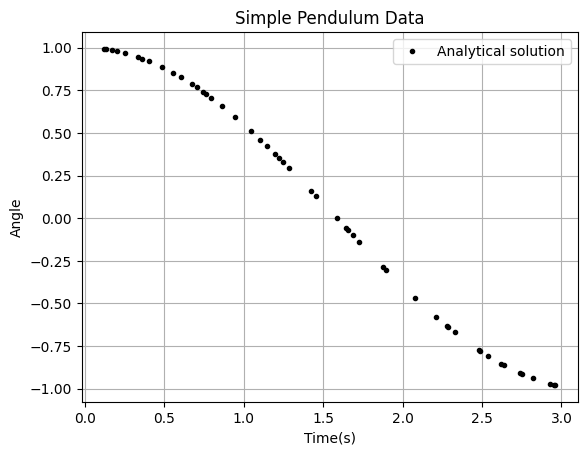

In [4]:
tc.manual_seed(42) # fixing the random number generator seed
indices = tc.multinomial(input=tc.ones(len(t_train)), num_samples=50, replacement=False) #len(x_train)//10
plt.plot(t_train[indices].detach().numpy(), theta_train[indices].detach().numpy(), "k.", label="Analytical solution")

# Adding labels and title
plt.ylabel("Angle")
plt.xlabel("Time(s)")
plt.title("Simple Pendulum Data")
plt.legend()
plt.grid(True)
plt.show()

Our goal is to learn what the acceleration due to gravity is. To do this, we will consider that we know the angle theta at each instant of time, the length of the pendulum, and the initial angle, as represented in the figure above.

Our neural network will represent one of the parameters of the solution:

$$
\theta(t) = \theta_0 \cos(\omega t)
$$
where $\omega = \sqrt{\frac{g}{l}}$, where $g$ is gravity and $l$ is the length of the pendulum.

For our application, we will assume that we do not know the value of $g$, but we will leave the expression in terms of $\omega$. Knowing the value of $\omega$ and $l$, we can obtain $g$ through the expression:

$$
g = \omega^2 \cdot l
$$

Note that this is a very simple objective, the aim is just to illustrate to the reader how we can use the neural network to learn a physical parameter.

Let's initialize the network, declare the optimizer, and also a scheduler, i.e., a function that modifies the learning rate, $\eta$, every specific number of steps.


In [5]:
# Defining the neural network
net = GravityNet(neurons=1, M=1, activation=nn.Tanh())

# Loss and optimizer
optimizer = tc.optim.Adam(net.parameters(), lr=0.001) # defining the optimizer

# Creating a scheduler to decrease the learning rate every 'step_size' epochs
scheduler = StepLR(optimizer, step_size=10000, gamma=0.9)

Iniciamos o treinamento

In [6]:
# loss
LOSS = []

# Training
for epoch in range(5000):
    omega = net(t_train)
    # If we observe the variable "gravity" it is a vector, with size equal to t_train
    # to use it as a parameter it must be just a number
    # Therefore we will take the average of this vector to use as gravity.
    w = tc.mean(omega)

    #theta_neuralnetwork = x_0*tc.cos(tc.sqrt(g/pendulum_length)*t_train)
    theta_NN = x_0*tc.cos(w*t_train)  
    loss1 = tc.mean((theta_train-theta_NN)**2)

    # we can impose that, regardless of the input, the parameter must be the same
    loss2 = tc.mean(abs(omega-w))
    loss = loss1 + loss2

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    LOSS.append(loss.item())

gravity = net(t_train) # Neural network
freq = gravity.mean().detach().numpy()
print("Value of gravitational acceleration", freq**2*pendulum_length)

Value of gravitational acceleration tensor(9.7540)


Note that this value is not exactly the value of gravity, it is an approximate value.
$$g \approx g'$$

And even so, it satisfies the theoretical curve, using the exact value of gravity.


In [7]:
# Our error was
print("Error:", abs(freq**2*pendulum_length - 9.81))

Error: tensor(0.0560)


Which for our problem, is a small error

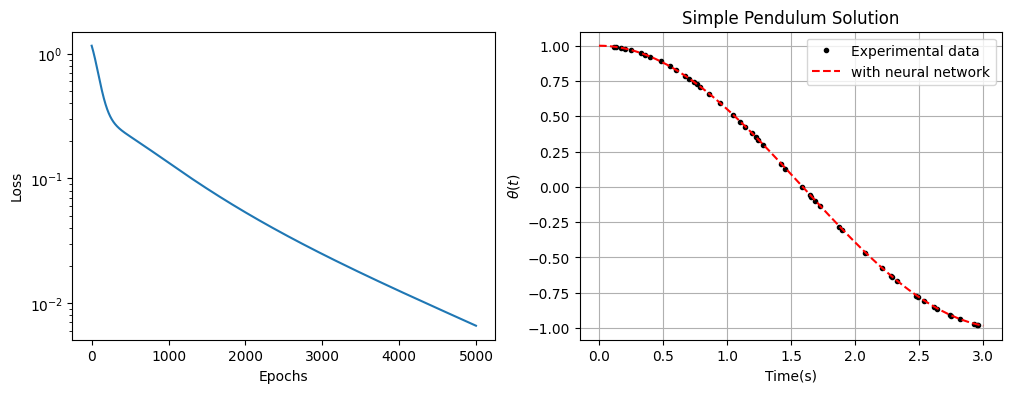

In [8]:
w = tc.mean(net(t_train))
theta_NN = x_0 * tc.cos(w * t_train)

# Defining the figure size (width, height) in inches
plt.figure(figsize=(12, 4))  # Increase the values as needed

plt.subplot(1, 2, 1)
plt.plot(LOSS)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.subplot(1, 2, 2)
plt.plot(t_train[indices].detach().numpy(), theta_train[indices].detach().numpy(), 'k.', label="Experimental data")
plt.plot(t_train.detach().numpy(), theta_NN.detach().numpy(), 'r--', label="with neural network")
# Adding labels and title
plt.ylabel(r"$\theta(t)$")
plt.xlabel("Time(s)")
plt.title("Simple Pendulum Solution")
plt.legend()
plt.grid()
plt.show()


We can use the result to predict the region outside the training domain. Note that in the example above, the time is at most 3 seconds. Let's extend t to 20 seconds and see that the value found for the network parameter is sufficiently close to still be very close to the analytical solution.

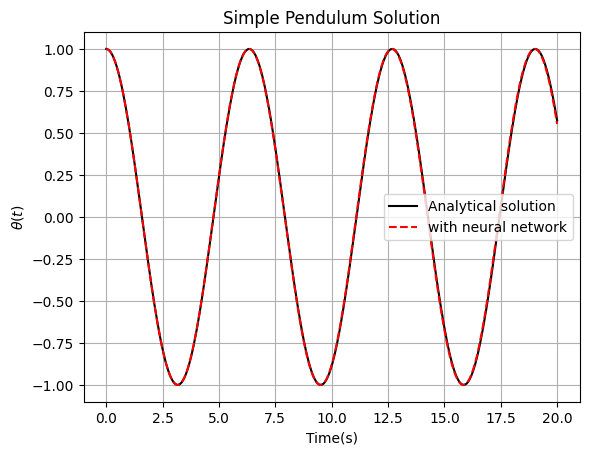

In [9]:
# Creating training data
t_train = tc.linspace(0, 20, 300).reshape(-1, 1) # Time
theta_train = analytical_solution_OHM(x_0=x_0, omega_0=Omega_0, t=t_train) # Analytical solution of the OHS

w = tc.mean(net(t_train))
theta_NN = x_0 * tc.cos(w * t_train)

plt.plot(t_train.detach().numpy(), theta_train.detach().numpy(), 'k-', label="Analytical solution")
plt.plot(t_train.detach().numpy(), theta_NN.detach().numpy(), 'r--', label="with neural network")
# Adding labels and title
plt.ylabel(r"$\theta(t)$")
plt.xlabel("Time(s)")
plt.title("Simple Pendulum Solution")
plt.legend()
plt.grid()
plt.show()

# Extra Example

We are using automatic differentiation available in PyTorch to learn the value of gravity and the initial position.

In this case, we are considering that we have some experimental data representing the values of theta for each instant of time.

Our goal is to discover the "experimental parameters"
$$
\theta(t) = \theta_0 \cos\left(\sqrt{\frac{g}{l}} t\right)
$$

In this case, as we have already done for $g$, we can now compose the network with the previous one and seek to find $\theta_0$, i.e., use the information from the previous parameter to find a new one.


In [10]:
import torch as tc
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Defining the network
class GravityNet(nn.Module):
    def __init__(self):
        super(GravityNet, self).__init__()
        self.g = tc.tensor(0.98) 
        #self.g = nn.Parameter(tc.rand(1))
        self.x0 = nn.Parameter(tc.rand(1))


In [11]:
# Data
x_0 = 1
g_true = 0.98
l_pendulum = 0.5

t_train = tc.linspace(0, 10, 100).unsqueeze(1)  # ensuring t_train is a column
theta_train = x_0 * tc.cos(tc.sqrt(tc.tensor(g_true) / l_pendulum) * t_train)

# Initialization
net = GravityNet()
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

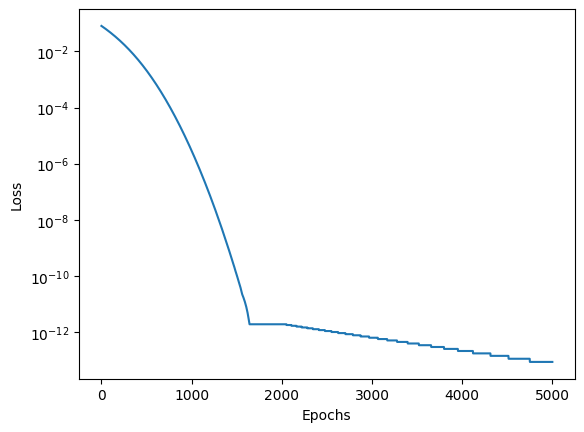

In [12]:
# Training
LOSS = []
for epoch in range(5000):
    
    theta_NN = net.x0 * tc.cos(tc.sqrt(net.g / l_pendulum) * t_train)
    
    loss = loss_fn(theta_train, theta_NN)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    LOSS.append(loss.item())
# Plot
plt.plot(LOSS)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [13]:
print("Value of g: ", net.g.detach().numpy(), "\nValue of x0:", net.x0.detach().numpy())

Value of g:  0.98 
Value of x0: [0.9999996]


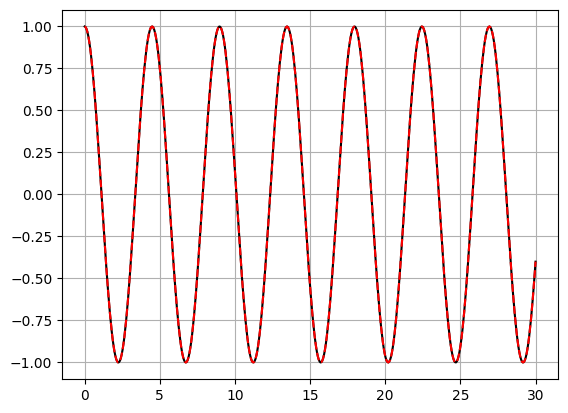

In [14]:
t_train = tc.linspace(0, 30, 500).unsqueeze(1)  # ensuring t_train is a column
theta_train = x_0 * tc.cos(tc.sqrt(tc.tensor(g_true) / l_pendulum) * t_train)
theta_NN = net.x0 * tc.cos(tc.sqrt(net.g / l_pendulum) * t_train)

plt.plot(t_train.detach().numpy(), theta_train.detach().numpy(), 'k')
plt.plot(t_train.detach().numpy(), theta_NN.detach().numpy(), 'r--')
plt.grid()
plt.show()